## Carregamento do Dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import kagglehub


c:\Users\ediad\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Baixar o dataset do Kaggle
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")
print("Path to dataset files:", path)

# Carregar o arquivo CSV
csv_path = path + "/StudentsPerformance.csv"
df = pd.read_csv(csv_path)
df.head()

Path to dataset files: C:\Users\ediad\.cache\kagglehub\datasets\spscientist\students-performance-in-exams\versions\1


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Nº de nós: 990
Nº de arestas: 18840


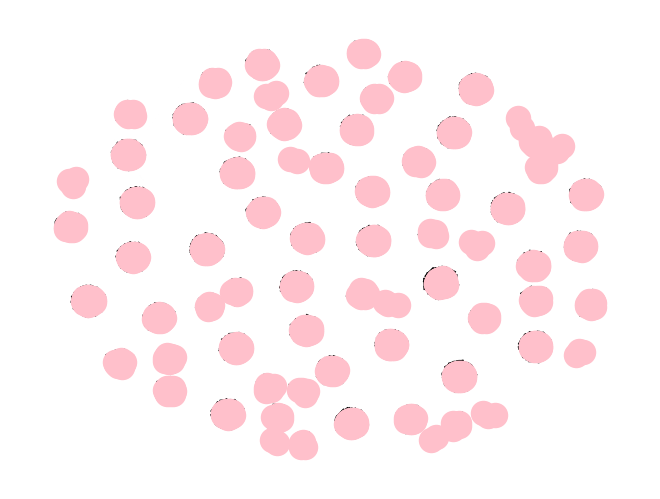

In [4]:
# Exemplo: Criando um grafo dirigido onde cada nó é um estudante e há uma aresta se dois estudantes têm a mesma nota de matemática
G = nx.DiGraph()
for i, row_i in df.iterrows():
    for j, row_j in df.iterrows():
        if i != j and row_i['math score'] == row_j['math score']:
            G.add_edge(i, j)

print(f'Nº de nós: {G.number_of_nodes()}')
print(f'Nº de arestas: {G.number_of_edges()}')
nx.draw(G, with_labels=False, node_color='pink', arrowsize=20)
plt.savefig("imagens/estrutura_grafo.png")
plt.show()

In [5]:
# Função para calcular o PageRank manualmente
def pagerank_manual(G, d=0.85, max_iter=100, tol=1e-6):
    N = G.number_of_nodes()
    pr = {node: 1/N for node in G.nodes()}
    for i in range(max_iter):
        pr_new = {}
        for node in G.nodes():
            rank = (1 - d) / N
            for nbr in G.predecessors(node):
                rank += d * pr[nbr] / G.out_degree(nbr) if G.out_degree(nbr) > 0 else 0
            pr_new[node] = rank
        err = sum(abs(pr_new[n] - pr[n]) for n in G.nodes())
        pr = pr_new
        if err < tol:
            print(f'Convergiu em {i+1} iterações')
            break
    return pr

In [6]:
# Calcular PageRank manual (usando função já implementada)
pr_manual = pagerank_manual(G, d=0.85)
print('PageRank manual (top 10):')
print(sorted(pr_manual.items(), key=lambda x: x[1], reverse=True)[:10])

# Calcular PageRank com NetworkX para comparação
pr_nx = nx.pagerank(G, alpha=0.85)
print('PageRank NetworkX (top 10):')
print(sorted(pr_nx.items(), key=lambda x: x[1], reverse=True)[:10])

Convergiu em 1 iterações
PageRank manual (top 10):
[(10, 0.0010101010101010108), (41, 0.0010101010101010108), (58, 0.0010101010101010108), (70, 0.0010101010101010108), (88, 0.0010101010101010108), (98, 0.0010101010101010108), (105, 0.0010101010101010108), (135, 0.0010101010101010108), (167, 0.0010101010101010108), (209, 0.0010101010101010108)]
PageRank NetworkX (top 10):
[(0, 0.0010101010101010103), (83, 0.0010101010101010103), (126, 0.0010101010101010103), (170, 0.0010101010101010103), (226, 0.0010101010101010103), (345, 0.0010101010101010103), (459, 0.0010101010101010103), (467, 0.0010101010101010103), (547, 0.0010101010101010103), (642, 0.0010101010101010103)]


## Análise dos Resultados do PageRank
Vamos identificar os estudantes mais relevantes segundo o PageRank, discutir o impacto do parâmetro d e visualizar os resultados.

Top estudantes pelo PageRank manual:
ID: 10, Score: 0.0010101010101010108, Dados: {'gender': 'male', 'race/ethnicity': 'group C', 'parental level of education': "associate's degree", 'lunch': 'standard', 'test preparation course': 'none', 'math score': 58, 'reading score': 54, 'writing score': 52}
ID: 41, Score: 0.0010101010101010108, Dados: {'gender': 'female', 'race/ethnicity': 'group C', 'parental level of education': "associate's degree", 'lunch': 'standard', 'test preparation course': 'none', 'math score': 58, 'reading score': 73, 'writing score': 68}
ID: 58, Score: 0.0010101010101010108, Dados: {'gender': 'male', 'race/ethnicity': 'group D', 'parental level of education': 'some college', 'lunch': 'standard', 'test preparation course': 'completed', 'math score': 58, 'reading score': 59, 'writing score': 58}
ID: 70, Score: 0.0010101010101010108, Dados: {'gender': 'female', 'race/ethnicity': 'group D', 'parental level of education': 'some college', 'lunch': 'free/reduced', 'test pre

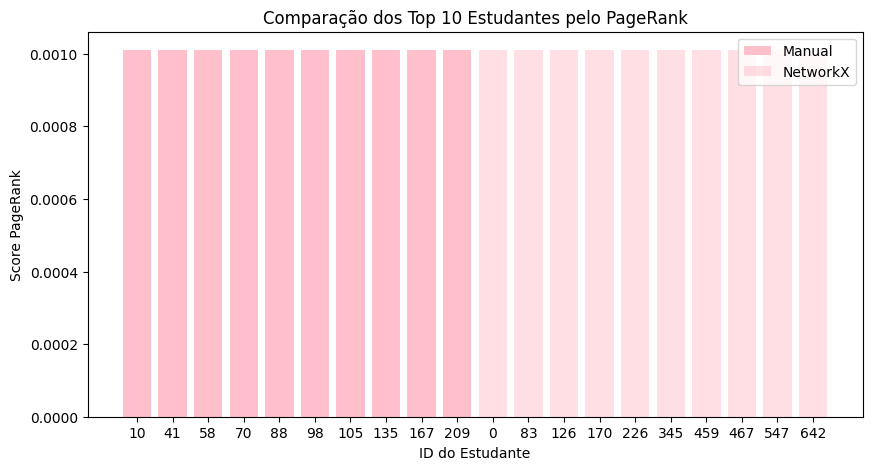

In [7]:
# Visualizar os top estudantes pelo PageRank manual
top_manual = sorted(pr_manual.items(), key=lambda x: x[1], reverse=True)[:10]
print('Top estudantes pelo PageRank manual:')
for idx, score in top_manual:
    print(f'ID: {idx}, Score: {score}, Dados:', df.iloc[idx].to_dict())

# Visualizar os top estudantes pelo PageRank NetworkX
top_nx = sorted(pr_nx.items(), key=lambda x: x[1], reverse=True)[:10]
print('\nTop estudantes pelo PageRank NetworkX:')
for idx, score in top_nx:
    print(f'ID: {idx}, Score: {score}, Dados:', df.iloc[idx].to_dict())

# Visualização dos scores dos top 10
plt.figure(figsize=(10,5))
plt.bar([str(idx) for idx, _ in top_manual], [score for _, score in top_manual], label='Manual', color='pink')
plt.bar([str(idx) for idx, _ in top_nx], [score for _, score in top_nx], alpha=0.5, label='NetworkX', color='pink')
plt.xlabel('ID do Estudante')
plt.ylabel('Score PageRank')
plt.title('Comparação dos Top 10 Estudantes pelo PageRank')
plt.legend()
plt.savefig("imagens/pagerank_top10.png")
plt.show()

## Impacto do Parâmetro d no PageRank
Vamos variar o parâmetro d (damping factor) e analisar como isso afeta o ranking dos estudantes.

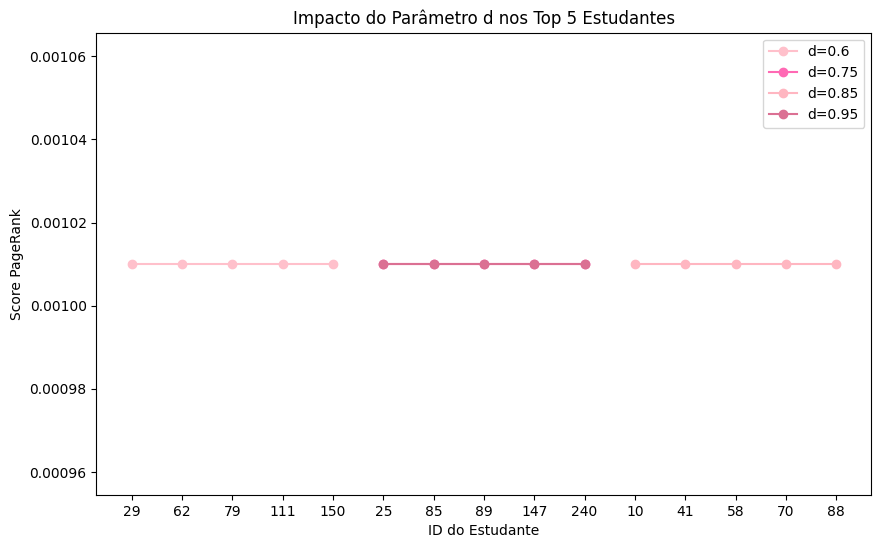

In [10]:
# Visualização do impacto de d em tons de rosa
plt.figure(figsize=(10,6))
rosa_tons = ['#FFC0CB', '#FF69B4', '#FFB6C1', '#DB7093']
for i, d in enumerate(d_values):
    plt.plot([str(idx) for idx, _ in results[d]], [score for _, score in results[d]], marker='o', label=f'd={d}', color=rosa_tons[i % len(rosa_tons)])
plt.xlabel('ID do Estudante')
plt.ylabel('Score PageRank')
plt.title('Impacto do Parâmetro d nos Top 5 Estudantes')
plt.savefig("imagens/impacto_d_pagerank.png")
plt.legend()
plt.show()


## PageRank no Grafo Real: Zachary's Karate Club
Vamos aplicar o PageRank no famoso grafo de amizades do clube de karatê de Zachary, disponível no NetworkX.

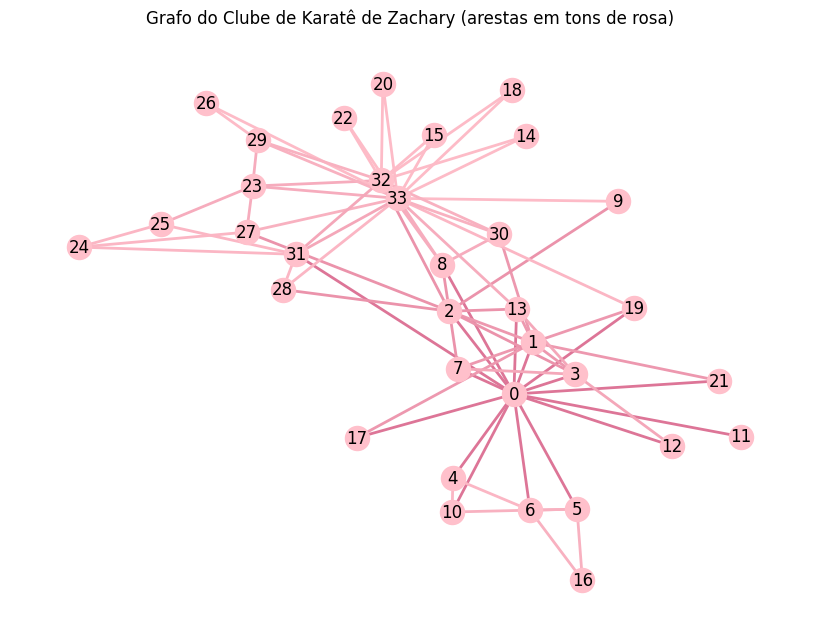

Convergiu em 30 iterações
PageRank manual (karate) - Top 10:
[(33, 0.10091893648817557), (0, 0.09699751091990579), (32, 0.07169303486619164), (2, 0.057078501106171735), (1, 0.05287698331446429), (31, 0.037158030709511077), (3, 0.035859912146847306), (23, 0.03152243116289058), (8, 0.029766035914728088), (13, 0.029536480435382068)]

PageRank NetworkX (karate) - Top 10:
[(33, 0.09698041880501741), (0, 0.08850807396280012), (32, 0.07592643687005646), (2, 0.06276686454603017), (1, 0.057414840497110056), (31, 0.04198548926127872), (23, 0.04114596964602211), (3, 0.03721208153631377), (5, 0.03381044255357727), (13, 0.033474187085322404)]


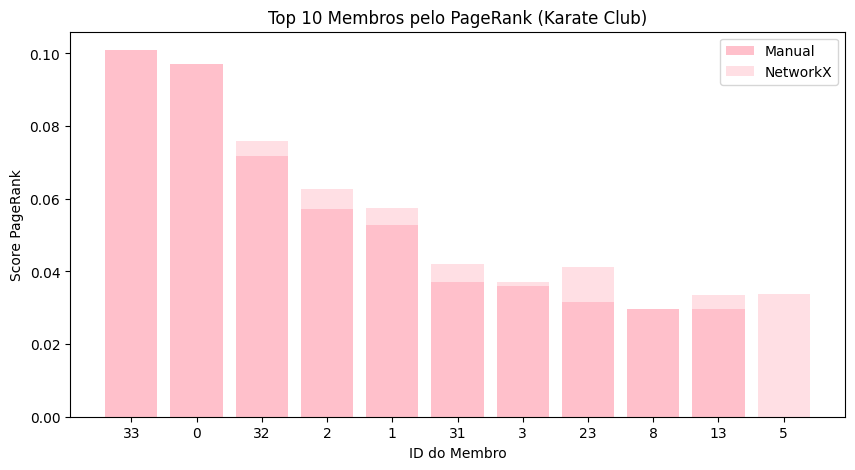

In [14]:
from matplotlib.colors import to_rgb

# Carregar o grafo do clube de karatê de Zachary
G_karate = nx.karate_club_graph()

# Calcular grau dos nós para definir intensidade das arestas
edges, weights = zip(*nx.degree(G_karate))
max_weight = max(weights)
min_weight = min(weights)

# Normalizar pesos para cor
def edge_color_intensity(weight, min_w, max_w):
    # Quanto maior o peso, mais forte o rosa
    norm = (weight - min_w) / (max_w - min_w) if max_w > min_w else 0
    # Interpolar entre rosa claro e rosa forte
    rosa_claro = np.array(to_rgb('#FFC0CB'))
    rosa_forte = np.array(to_rgb('#DB7093'))
    cor = rosa_claro * (1-norm) + rosa_forte * norm
    return cor

edge_colors = [edge_color_intensity(G_karate.degree(u), min_weight, max_weight) for u, v in G_karate.edges()]

plt.figure(figsize=(8,6))
nx.draw(
    G_karate,
    with_labels=True,
    node_color='#FFC0CB',
    edge_color=edge_colors,
    width=2
)
plt.title('Grafo do Clube de Karatê de Zachary (arestas em tons de rosa)')
plt.savefig("imagens/grafo_karate.png")
plt.show()

# Converter para grafo dirigido
G_karate_dir = G_karate.to_directed()

# Aplicar PageRank manual e NetworkX
pr_manual_karate = pagerank_manual(G_karate_dir, d=0.85)
pr_nx_karate = nx.pagerank(G_karate_dir, alpha=0.85)

print('PageRank manual (karate) - Top 10:')
print(sorted(pr_manual_karate.items(), key=lambda x: x[1], reverse=True)[:10])

print('\nPageRank NetworkX (karate) - Top 10:')
print(sorted(pr_nx_karate.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10,5))
top_manual_karate = sorted(pr_manual_karate.items(), key=lambda x: x[1], reverse=True)[:10]
top_nx_karate = sorted(pr_nx_karate.items(), key=lambda x: x[1], reverse=True)[:10]
plt.bar([str(idx) for idx, _ in top_manual_karate], [score for _, score in top_manual_karate], label='Manual', color='#FFC0CB')
plt.bar([str(idx) for idx, _ in top_nx_karate], [score for _, score in top_nx_karate], alpha=0.5, label='NetworkX', color='#FFC0CB')
plt.xlabel('ID do Membro')
plt.ylabel('Score PageRank')
plt.title('Top 10 Membros pelo PageRank (Karate Club)')
plt.legend()
plt.savefig("imagens/pagerank_karate_top10.png")
plt.show()